In [1]:
# --- Visualize GT (green) + Preds (red) for 10 test samples with PIL only ---

import json, random
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

from rfdetr import RFDETRBase

# ---- paths & config ----
test_dir  = Path("dataset_clean/test")       # <- your clean test split
ann_path  = test_dir / "_annotations.coco.json"
ckpt_path = Path("outputs_10_epochs/checkpoint_best_ema.pth")   # <- use your trained checkpoint
conf_th   = 0.5
NUM_SAMPLES = 10
assert ann_path.exists(), f"Missing {ann_path}"
assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path}"

# ---- load model (no supervision; robust to api diffs) ----
model = RFDETRBase(pretrain_weights=str(ckpt_path))
try:
    model.optimize_for_inference()
except Exception:
    pass

# ---- COCO helpers ----
with open(ann_path, "r") as f:
    coco = json.load(f)

img_by_id = {im["id"]: im for im in coco["images"]}
anns_by_img = {}
for a in coco["annotations"]:
    anns_by_img.setdefault(a["image_id"], []).append(a)

all_ids = [im["id"] for im in coco["images"] if (test_dir / im["file_name"]).exists()]
sample_ids = random.sample(all_ids, k=min(NUM_SAMPLES, len(all_ids)))

Loading pretrain weights


num_classes mismatch: pretrain weights has 0 classes, but your model has 90 classes
reinitializing detection head with 0 classes
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [2]:
def xywh_to_xyxy(b):
    x,y,w,h = b
    return [x, y, x+w, y+h]

def draw_rect(draw: ImageDraw.Draw, box, color=(0,255,0), width=3):
    x1,y1,x2,y2 = map(int, box)
    for t in range(width):
        draw.rectangle([x1-t, y1-t, x2+t, y2+t], outline=color)

# Convert various predict() outputs into numpy arrays
def to_numpy(x):
    if x is None: return None
    if hasattr(x, "detach"): return x.detach().cpu().numpy()
    if hasattr(x, "cpu"):    return x.cpu().numpy()
    return np.asarray(x)

def parse_preds(pred):
    """
    Returns (xyxy[N,4], scores[N], labels[N]) all numpy arrays.
    Handles:
      - sv.Detections
      - dict with 'boxes'/'scores'/'labels'
      - list wrapping one of the above
    """
    try:
        import supervision as sv  # only to check type if present
        if isinstance(pred, sv.Detections):
            xyxy = pred.xyxy
            scores = pred.confidence if pred.confidence is not None else np.ones((len(pred),), dtype=float)
            labels = pred.class_id  if pred.class_id  is not None else np.zeros((len(pred),), dtype=int)
            return xyxy, scores, labels
    except Exception:
        pass

    if isinstance(pred, list) and len(pred) > 0:
        pred = pred[0]

    if isinstance(pred, dict):
        xyxy  = to_numpy(pred.get("boxes"))  or np.zeros((0,4), dtype=float)
        scores= to_numpy(pred.get("scores")) or np.ones((xyxy.shape[0],), dtype=float)
        labels= to_numpy(pred.get("labels")) or np.zeros((xyxy.shape[0],), dtype=int)
        return xyxy, scores, labels

    # Unknown type → treat as empty
    return np.zeros((0,4), dtype=float), np.zeros((0,), dtype=float), np.zeros((0,), dtype=int)


[1] 534_92e8ca97_F1_scaled.png  size=(1606x1493)  GT=15  Pred(≥0.5)=9
  GT[0]   xyxy=[924.6,645.0,945.6,730.5]
  GT[1]   xyxy=[632.3,1078.8,716.7,1093.8]
  Pred[0] xyxy=[1245.5,1047.1,1264.5,1117.2]  score=0.71
  Pred[1] xyxy=[928.5,929.8,949.8,1009.7]  score=0.71


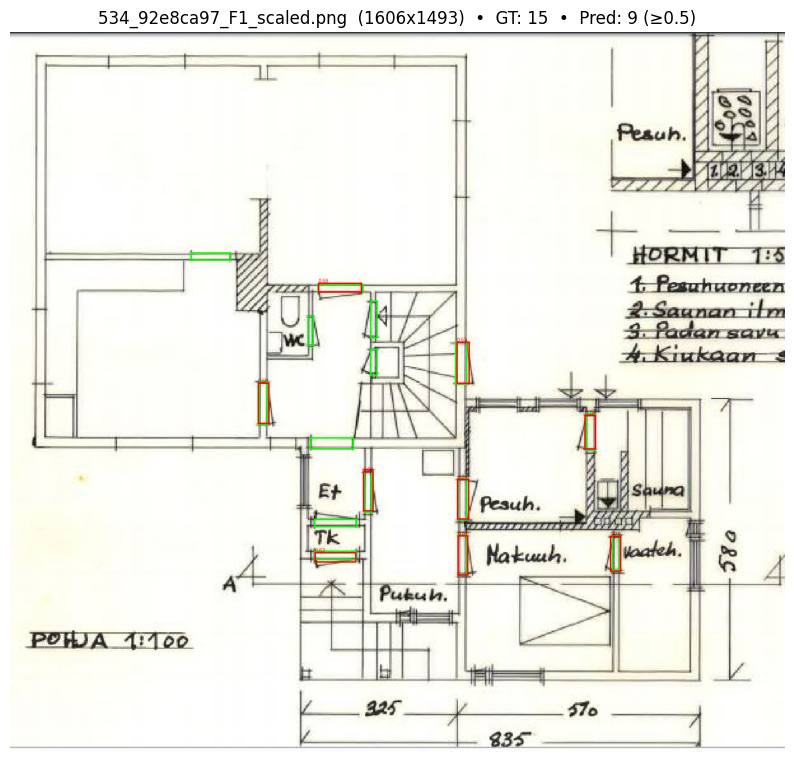


[2] 517_bb0f6721_F1_scaled.png  size=(1554x1002)  GT=6  Pred(≥0.5)=7
  GT[0]   xyxy=[1287.2,147.1,1319.2,290.1]
  GT[1]   xyxy=[614.6,814.8,702.9,834.8]
  Pred[0] xyxy=[617.3,815.7,703.6,835.8]  score=0.86
  Pred[1] xyxy=[561.2,374.3,632.5,395.5]  score=0.85


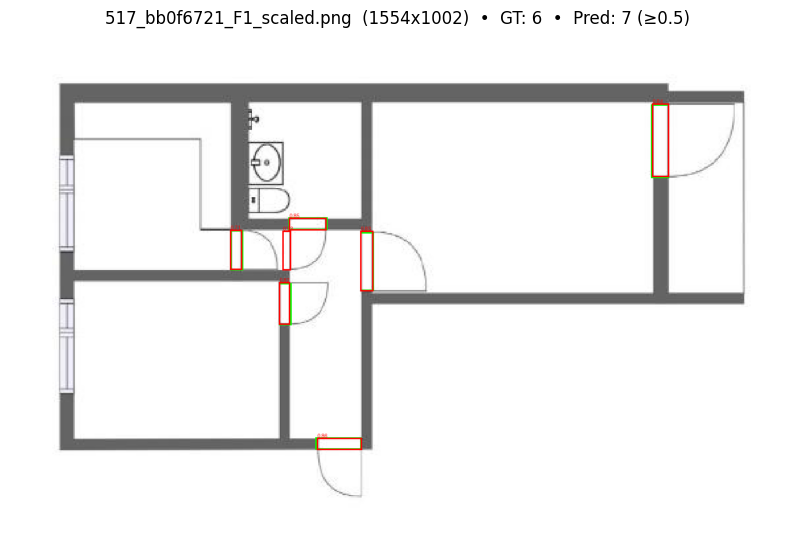


[3] 245_16a408ae_F1_scaled.png  size=(868x1007)  GT=6  Pred(≥0.5)=6
  GT[0]   xyxy=[607.7,835.8,706.2,857.8]
  GT[1]   xyxy=[66.0,339.6,159.8,351.6]
  Pred[0] xyxy=[719.6,442.0,730.3,516.2]  score=0.83
  Pred[1] xyxy=[614.8,353.5,700.2,365.3]  score=0.80


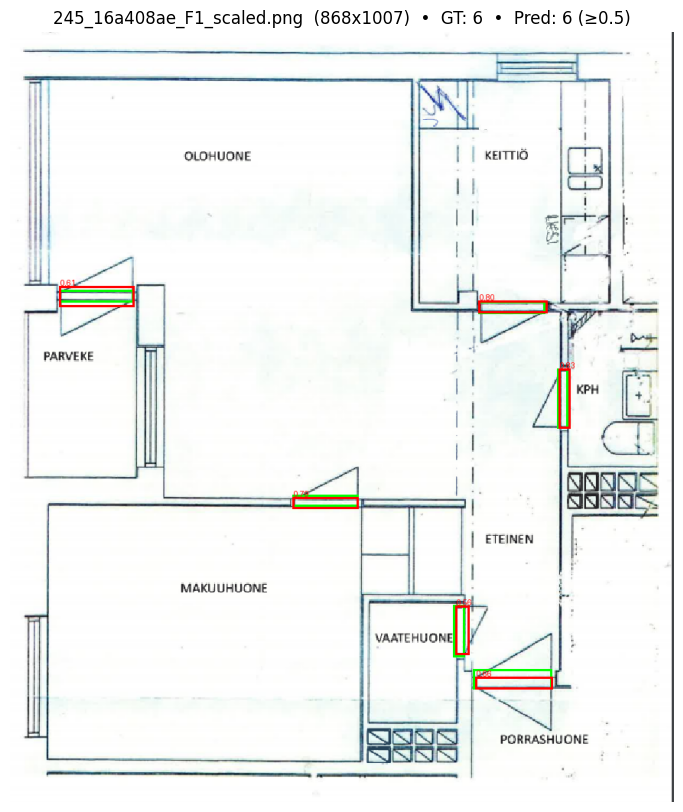


[4] 489_a4d53d61_F1_scaled.png  size=(848x1150)  GT=5  Pred(≥0.5)=4
  GT[0]   xyxy=[249.3,236.0,334.8,272.0]
  GT[1]   xyxy=[651.3,961.4,740.5,994.4]
  Pred[0] xyxy=[250.6,234.6,336.3,270.7]  score=0.88
  Pred[1] xyxy=[516.3,796.9,610.3,811.6]  score=0.69


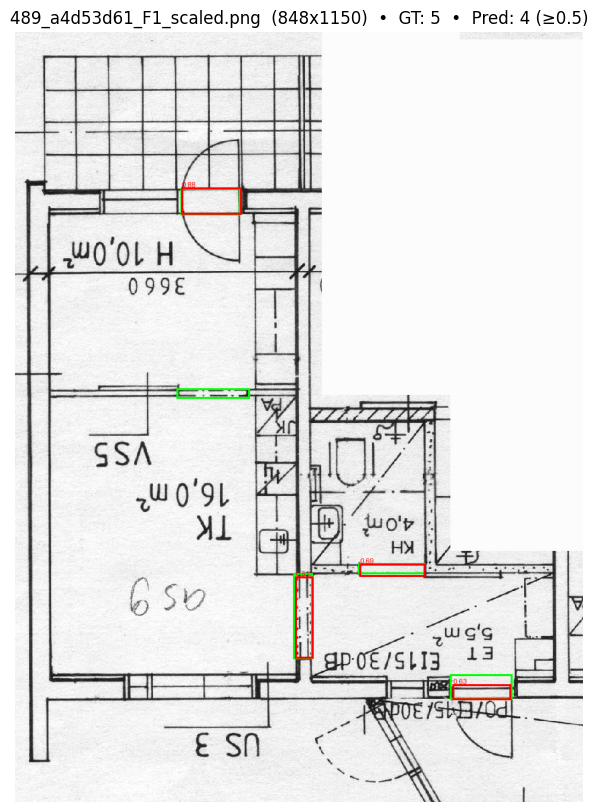


[5] 144_dbb5ef89_F1_scaled.png  size=(1365x1493)  GT=6  Pred(≥0.5)=5
  GT[0]   xyxy=[645.7,405.2,741.0,450.2]
  GT[1]   xyxy=[597.1,1251.7,688.1,1274.7]
  Pred[0] xyxy=[649.4,417.8,741.7,453.3]  score=0.82
  Pred[1] xyxy=[599.1,1254.5,687.8,1279.2]  score=0.81


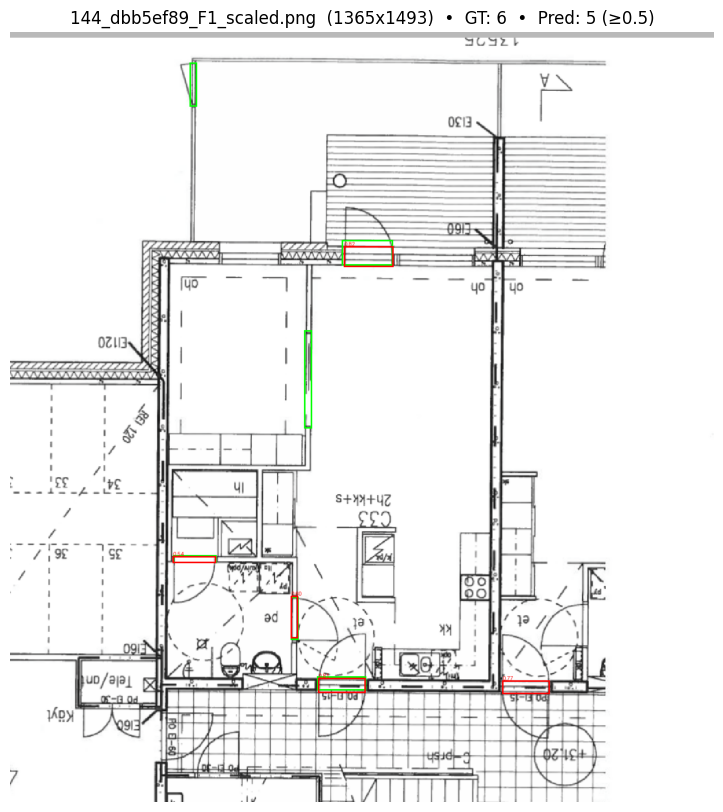


[6] 267_5c168013_F1_scaled.png  size=(1882x1477)  GT=13  Pred(≥0.5)=11
  GT[0]   xyxy=[465.1,1341.5,582.4,1356.5]
  GT[1]   xyxy=[997.8,1207.2,1106.1,1231.5]
  Pred[0] xyxy=[997.2,1200.4,1106.4,1225.6]  score=0.80
  Pred[1] xyxy=[806.2,984.9,879.1,1003.6]  score=0.72


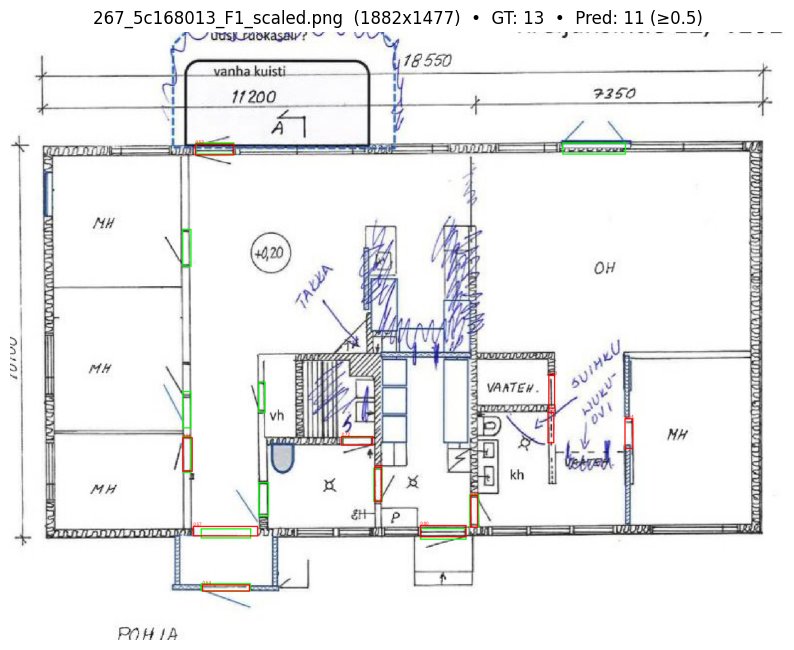


[7] 819_67af51a5_F1_scaled.png  size=(868x1931)  GT=8  Pred(≥0.5)=6
  GT[0]   xyxy=[265.9,1503.6,357.8,1520.6]
  GT[1]   xyxy=[397.2,577.5,478.2,615.2]
  Pred[0] xyxy=[399.3,577.8,479.5,604.7]  score=0.83
  Pred[1] xyxy=[266.9,1500.8,355.8,1521.3]  score=0.78


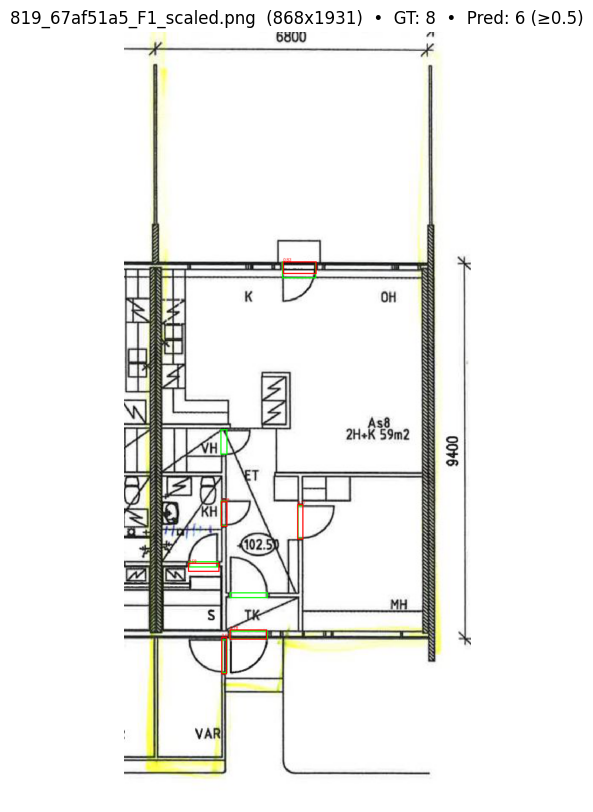


[8] 617_4fd45d50_F1_scaled.png  size=(3556x1575)  GT=12  Pred(≥0.5)=8
  GT[0]   xyxy=[1155.0,1258.9,1246.9,1281.9]
  GT[1]   xyxy=[476.8,567.4,502.1,661.8]
  Pred[0] xyxy=[1152.2,1018.2,1261.4,1039.0]  score=0.80
  Pred[1] xyxy=[473.2,570.1,501.4,659.2]  score=0.71


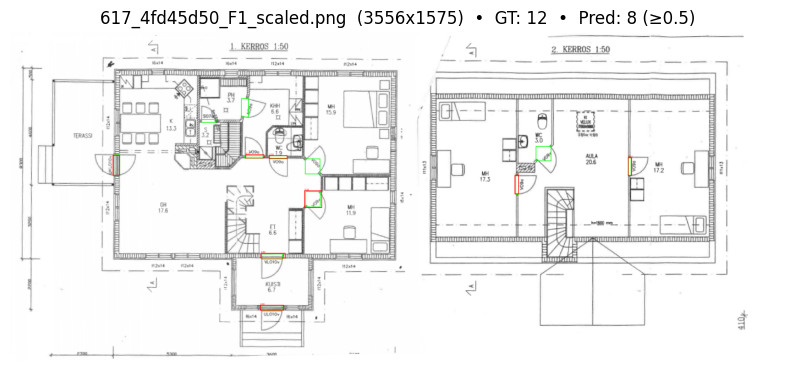


[9] 64_df128fad_F1_scaled.png  size=(1633x1248)  GT=8  Pred(≥0.5)=8
  GT[0]   xyxy=[981.0,1009.4,1060.2,1030.5]
  GT[1]   xyxy=[836.0,1009.4,917.8,1030.5]
  Pred[0] xyxy=[837.7,1009.1,916.5,1031.6]  score=0.85
  Pred[1] xyxy=[981.7,1010.2,1060.7,1031.6]  score=0.83


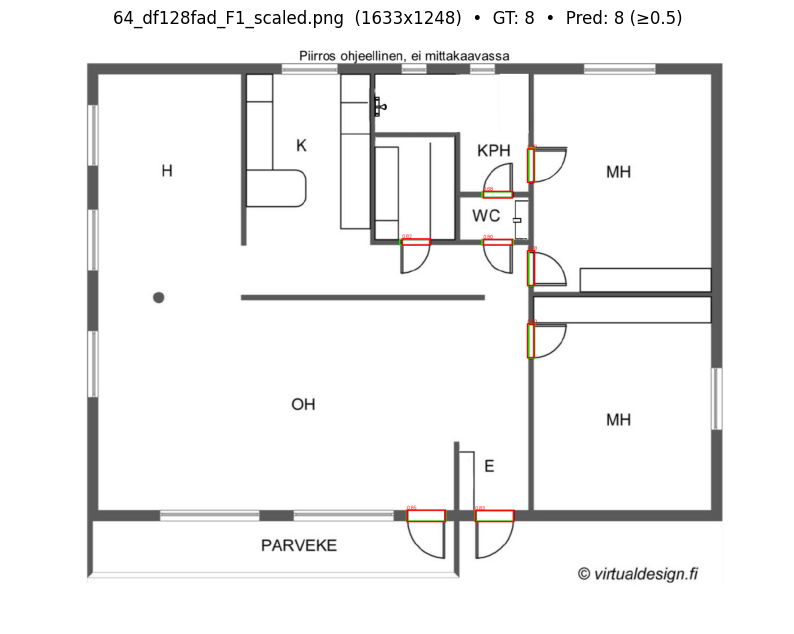


[10] 318_3bec18af_F1_scaled.png  size=(1343x1220)  GT=9  Pred(≥0.5)=11
  GT[0]   xyxy=[208.0,429.1,234.0,512.3]
  GT[1]   xyxy=[856.0,1119.5,936.4,1136.5]
  Pred[0] xyxy=[209.9,428.9,234.2,513.3]  score=0.80
  Pred[1] xyxy=[856.6,1120.6,937.4,1138.8]  score=0.74


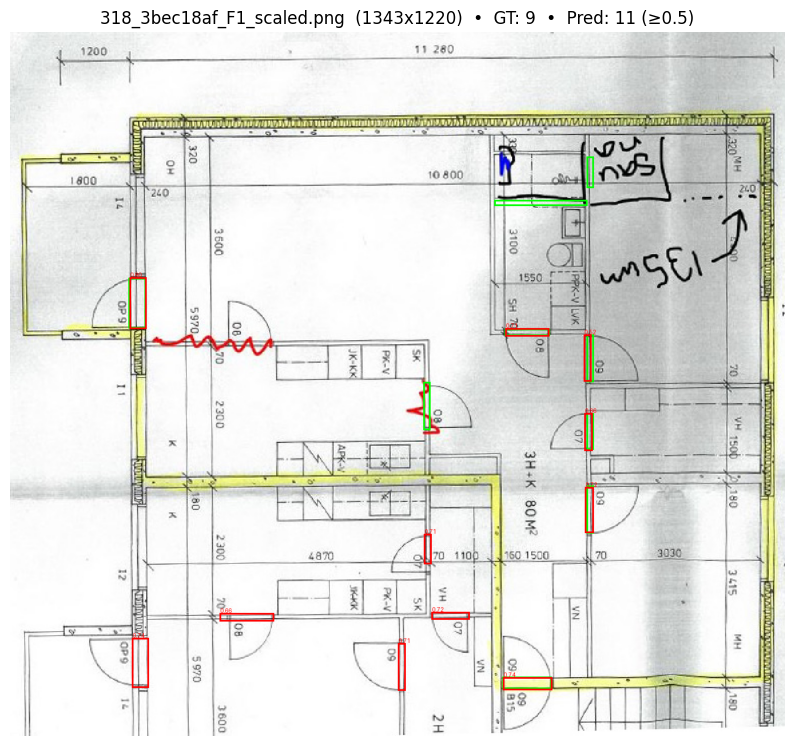

In [3]:
# ---- loop & show ----
for i, img_id in enumerate(sample_ids, 1):
    im = img_by_id[img_id]
    img_path = test_dir / im["file_name"]
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    # GT
    gt_anns = anns_by_img.get(img_id, [])
    gt_xyxy = np.array([xywh_to_xyxy(a["bbox"]) for a in gt_anns], dtype=np.float32) if gt_anns else np.zeros((0,4), dtype=np.float32)

    # Pred
    raw = model.predict(img, threshold=conf_th)  # some builds still return unfiltered → we will filter below
    pred_xyxy, pred_scores, pred_labels = parse_preds(raw)
    if pred_scores.size > 0:
        keep = pred_scores >= conf_th
        pred_xyxy  = pred_xyxy[keep]
        pred_scores= pred_scores[keep]
        pred_labels= pred_labels[keep]

    # Print brief info
    def fmt(b): return f"[{b[0]:.1f},{b[1]:.1f},{b[2]:.1f},{b[3]:.1f}]"
    print(f"\n[{i}] {img_path.name}  size=({W}x{H})  GT={len(gt_xyxy)}  Pred(≥{conf_th})={len(pred_xyxy)}")
    for j in range(min(2, len(gt_xyxy))):
        print(f"  GT[{j}]   xyxy={fmt(gt_xyxy[j])}")
    for j in range(min(2, len(pred_xyxy))):
        print(f"  Pred[{j}] xyxy={fmt(pred_xyxy[j])}  score={float(pred_scores[j]):.2f}")

    # Draw overlay: GT green, Pred red (+ score label)
    vis = img.copy()
    draw = ImageDraw.Draw(vis)
    # GT
    for box in gt_xyxy:
        draw_rect(draw, box, color=(0,255,0), width=3)
    # Pred
    for box, s in zip(pred_xyxy, pred_scores):
        draw_rect(draw, box, color=(255,0,0), width=3)
        x1,y1,_,_ = map(int, box)
        draw.text((x1, max(0, y1-12)), f"{s:.2f}", fill=(255,0,0))

    # Show inline
    plt.figure(figsize=(10, 10))
    plt.title(f"{img_path.name}  ({W}x{H})  •  GT: {len(gt_xyxy)}  •  Pred: {len(pred_xyxy)} (≥{conf_th})")
    plt.imshow(vis)
    plt.axis("off")
    plt.show()